In [ ]:
# Mount drive to load training data annotated with labelme
from google.colab import drive
drive.mount('/content/drive')

# Example of training data configuration
# data
# ├── test
# │   ├── example_img_1.tif
# │   └── example_labels_1.json
# └── train
#     ├── example_img_2.tif
#     └── example_labels_2.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Lite installation of Detectron2 w/o optional features, may need full installation for future use-cases
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [ ]:
# Import Detectron2 and dependencies once it is installed
# Verify version compatibility to avoid errors
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Additional imports
import torchvision
import cv2

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
# Unpack labelme annotations into a dictionary that Detectron2 can read
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["height"] = 400 # dimensions may change depending on the training set
        record["width"] = 1024

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # polygon for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
# Register the training data
classes = ['keyhole', 'melt pool'] # maybe add classes for bubbles, anomolies in future work?

data_path = '/content/drive/MyDrive/data' # path should lead to base dir for training data, see docs for recommended file structure

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d,
        lambda d=d: get_data_dicts(os.path.join(data_path, d), classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [ ]:
# Get default config for instance segmentation (from https://detectron2.readthedocs.io/en/latest/tutorials/configs.html)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000 # maximum iterations
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # adjust for additional future classes

In [ ]:
# Build the trainer, most errors come from incorrectly configured directories
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[08/13 14:54:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
# Train according to cfg parameters
trainer.train()

[08/13 14:54:39 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[08/13 14:54:49 d2.utils.events]:  eta: 0:15:15  iter: 19  total_loss: 2.099  loss_cls: 1.15  loss_box_reg: 0.1614  loss_mask: 0.6911  loss_rpn_cls: 0.07997  loss_rpn_loc: 0.02179    time: 0.4662  last_time: 0.5124  data_time: 0.0207  last_data_time: 0.0287   lr: 4.9953e-06  max_mem: 2130M
[08/13 14:54:59 d2.utils.events]:  eta: 0:15:23  iter: 39  total_loss: 1.893  loss_cls: 0.9582  loss_box_reg: 0.1622  loss_mask: 0.6829  loss_rpn_cls: 0.06892  loss_rpn_loc: 0.02205    time: 0.4775  last_time: 0.4794  data_time: 0.0163  last_data_time: 0.0067   lr: 9.9902e-06  max_mem: 2130M
[08/13 14:55:08 d2.utils.events]:  eta: 0:15:21  iter: 59  total_loss: 1.558  loss_cls: 0.6377  loss_box_reg: 0.1706  loss_mask: 0.6664  loss_rpn_cls: 0.05551  loss_rpn_loc: 0.02236    time: 0.4784  last_time: 0.4743  data_time: 0.0100  last_data_time: 0.0083   lr: 1.4985e-05  max_mem: 2130M
[08/13 14:55:18 d2.utils.events]:  eta: 0:15:06  iter: 79  total_loss: 1.321  loss_cls: 0.4228  loss_box_reg: 0.1907  loss_

In [ ]:
# Set up cfg for testing
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("pool_test", )
predictor = DefaultPredictor(cfg)

[08/13 15:16:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
# Get test dictionaries
test_dataset_dicts = get_data_dicts(data_path+'/test', classes) # 'file_name', 'height', 'width', 'annotations'

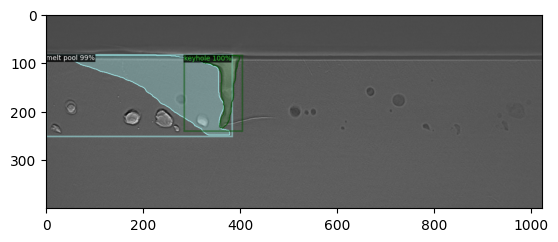

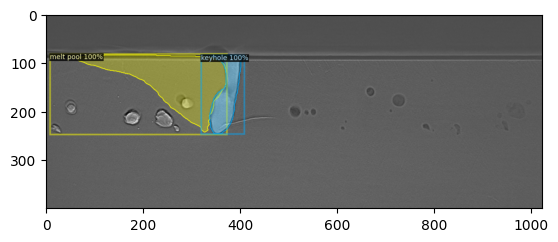

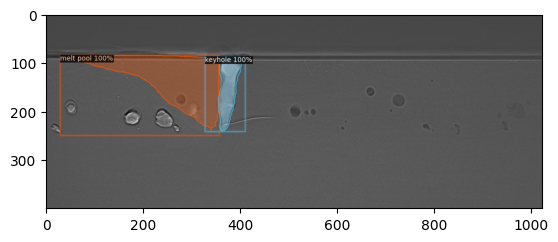

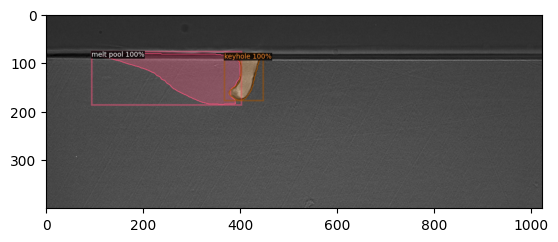

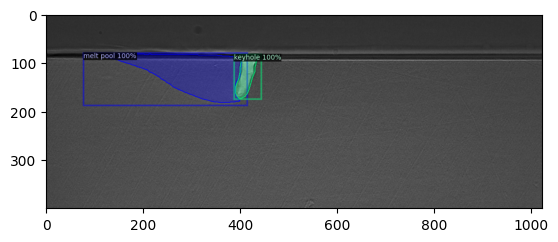

In [ ]:
# Test inference and visualize
for d in random.sample(test_dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata,
                   scale=1.0,
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()